True trace of f(A): 2.0899675721462696
Empirical mean: 2.0894406822998097
Empirical variance: 0.008906076294502196
Empirical std: 0.09437201012218716
Theoretical variance: 0.009377333899044953
Theoretical std: 0.0968366351080259


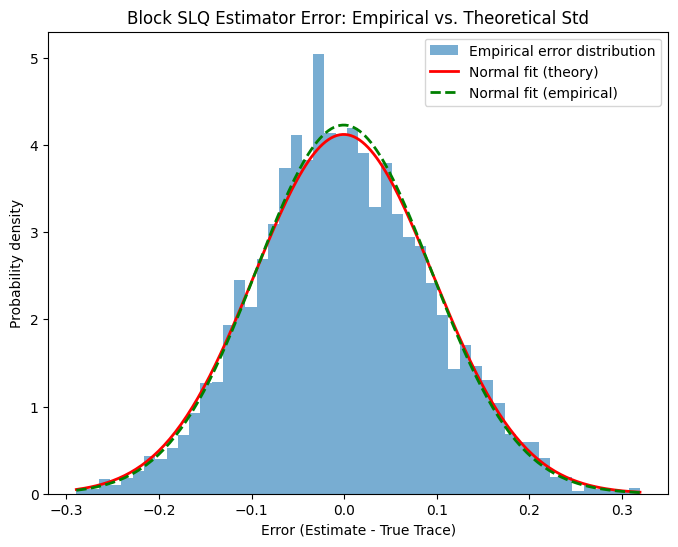

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Helper Functions (as defined earlier) ---

def generate_kernel_matrix(n, sigma=2.0):
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.exp(-((i - j)**2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    d = n - j
    z = np.zeros(d)
    z[0] = 1.0
    for _ in range(max_iter):
        Y_band = Y[:, j:n]
        r = Y_band.dot(z)
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0]**2)
        delta = np.linalg.solve(H, -g)
        z += delta
        if np.linalg.norm(delta) < tol:
            break
    return z

def estimate_cholesky(Y, m, n):
    L_est = np.zeros((n, n))
    for j in range(n):
        z = newton_column(Y, m, j, n)
        L_est[j:, j] = z
    return L_est

def A_mv_block(V, Sigma, L_est):
    return L_est.T @ (Sigma @ (L_est @ V))

# --- Simplified Block SLQ Estimator for Simulation ---
# (For simulation we compute f(A) explicitly.)

def block_slq_estimator(Sigma, L_est, block_size):
    """
    For simulation purposes only: we compute A = L_est^T Sigma L_est explicitly,
    then compute f(A) = A - log(A) - I, and then use a random block V.
    """
    n = L_est.shape[0]
    # Generate random block V with orthonormal columns
    Z = np.random.choice([-1,1], size=(n, block_size)).astype(np.float64)
    Q, _ = np.linalg.qr(Z)

    # Compute A explicitly
    A = L_est.T @ (Sigma @ L_est)
    # Diagonalize A to compute f(A)
    eigvals, eigvecs = np.linalg.eigh(A)
    def f(x):
        return x - np.log(x) - 1.0
    fA = eigvecs @ np.diag(f(eigvals)) @ eigvecs.T

    # Block estimator: Y = tr(V^T f(A) V)
    Y = np.trace(Q.T @ fA @ Q)
    # Unbiased estimator: scale by (n/block_size)
    return (n/block_size)*Y

# --- Simulation to compare empirical variance with theory ---
np.random.seed(42)
n = 200
m_samples = 10000
Sigma = generate_kernel_matrix(n, sigma=2.0)
mean_vec = np.zeros(n)
Y_samples = np.random.multivariate_normal(mean_vec, Sigma, size=m_samples)
L_est = estimate_cholesky(Y_samples, m_samples, n)

# Compute the true trace via full eigen-decomposition:
A = L_est.T @ (Sigma @ L_est)
eigvals, _ = np.linalg.eigh(A)
def f(x):
    return x - np.log(x) - 1.0
true_trace = np.sum(f(eigvals))
print("True trace of f(A):", true_trace)

# Monte Carlo simulation of block SLQ estimates:
num_trials = 5000
block_size = 5
b = block_size
estimates = np.array([block_slq_estimator(Sigma, L_est, block_size) for _ in range(num_trials)])

# Empirical variance (of the estimator X)
empirical_mean = np.mean(estimates)
empirical_var = np.var(estimates, ddof=1)
empirical_std = np.sqrt(empirical_var)
print("Empirical mean:", empirical_mean)
print("Empirical variance:", empirical_var)
print("Empirical std:", empirical_std)

# The theoretical variance, according to our derivation, is:
# Var(X) = (2n/(b(n+2)))[||f(A)||_F^2 - (tr(f(A)))^2/n]((b - b(b-1)/(n-1))/b)
fA = eigvecs @ np.diag(f(eigvals)) @ eigvecs.T  # but we already computed fA above
norm_fA_F2 = np.sum(f(eigvals)**2)  # since the Frobenius norm is invariant under orthogonal transform
theo_var = (2*n/(block_size*(n+2)))*(norm_fA_F2 - (true_trace**2)/n)*((b - b*(b-1)/(n-1))/b)
theo_std = np.sqrt(theo_var)
print("Theoretical variance:", theo_var)
print("Theoretical std:", theo_std)

# Plot the error distribution.
errors = estimates - true_trace
plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, density=True, alpha=0.6, label="Empirical error distribution")
x_vals = np.linspace(errors.min(), errors.max(), 200)
pdf_theo = norm.pdf(x_vals, loc=np.mean(errors), scale=theo_std)
plt.plot(x_vals, pdf_theo, 'r-', linewidth=2, label="Normal fit (theory)")
pdf_emp = norm.pdf(x_vals, loc=np.mean(errors), scale=empirical_std)
plt.plot(x_vals, pdf_emp, 'g--', linewidth=2, label="Normal fit (empirical)")
plt.xlabel("Error (Estimate - True Trace)")
plt.ylabel("Probability density")
plt.title("Block SLQ Estimator Error: Empirical vs. Theoretical Std")
plt.legend()
plt.show()


## Distribution of subblock eigenvalues

Probability that a random 51x51 subblock is full rank: 0.000


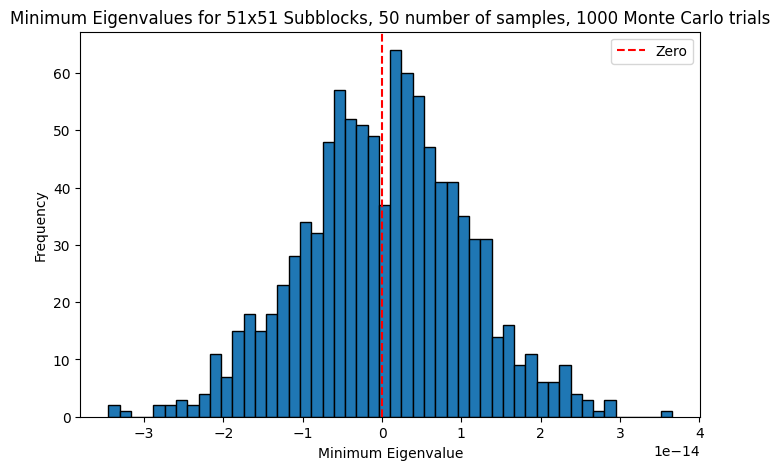

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_full_rank_subblock(n=200, m=50, s=30, iterations=1000, tol=1e-8):
    """
    Simulates the formation of A = L^T L with L drawn from i.i.d. Gaussian entries
    (representing sub-Gaussian random variables) and checks the full rank property for
    randomly selected s x s principal subblocks of A.

    Parameters:
      n : int
          Size of the covariance matrix A (n x n).
      m : int
          Sample size (number of rows in L); note that m << n.
      s : int
          Size of the subblock (s x s) to be examined; we require s <= m.
      iterations : int
          Number of simulation runs.
      tol : float
          Tolerance for determining whether an eigenvalue is positive.

    Returns:
      probability : float
          The empirical probability that a random s x s subblock is full rank.
      min_eigenvalues : list of floats
          The minimum eigenvalues of the subblocks over the simulation runs.
    """
    count_full_rank = 0
    min_eigenvalues = []

    for _ in range(iterations):
        # Generate L: m x n with i.i.d. standard Gaussian entries
        L = np.random.randn(m, n)
        # Form A = L^T L (which is n x n and has rank at most m)
        A = L.T @ L
        # print('Det of A:', np.linalg.det(A))

        # Randomly choose s indices out of n (the indices for the subblock)
        indices = np.sort(np.random.choice(n, s, replace=False))
        # Extract the s x s principal submatrix A_S corresponding to these indices
        A_S = A[np.ix_(indices, indices)]

        # Compute eigenvalues of the submatrix
        eigvals = np.linalg.eigvalsh(A_S)
        min_eig = np.min(eigvals)
        min_eigenvalues.append(min_eig)

        # Determine the numerical rank by counting eigenvalues above a tolerance
        rank = np.sum(eigvals > tol)
        if rank == s:
            count_full_rank += 1

    probability = count_full_rank / iterations
    return probability, min_eigenvalues

if __name__ == "__main__":
    # Parameters: choose n, m, and s so that s <= m and m << n.
    n = 200     # Total dimension of the covariance matrix
    m = 50      # Number of samples (effective rank is at most m)
    s = 51      # Subblock size (ensure s <= m)
    iterations = 1000   # Number of trials for the simulation

    prob, min_eigs = simulate_full_rank_subblock(n=n, m=m, s=s, iterations=iterations)
    print(f"Probability that a random {s}x{s} subblock is full rank: {prob:.3f}")

    # Plot a histogram of the minimum eigenvalues of the s x s subblocks.
    plt.figure(figsize=(8, 5))
    plt.hist(min_eigs, bins=50, edgecolor='black')
    plt.title(f"Minimum Eigenvalues for {s}x{s} Subblocks, {m} number of samples, 1000 Monte Carlo trials")
    plt.xlabel("Minimum Eigenvalue")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label="Zero")
    plt.legend()
    # plt.savefig('subblockeigs2.png', dpi=300)
    plt.show()


Probability that a random 30x30 subblock is full rank: 1.000


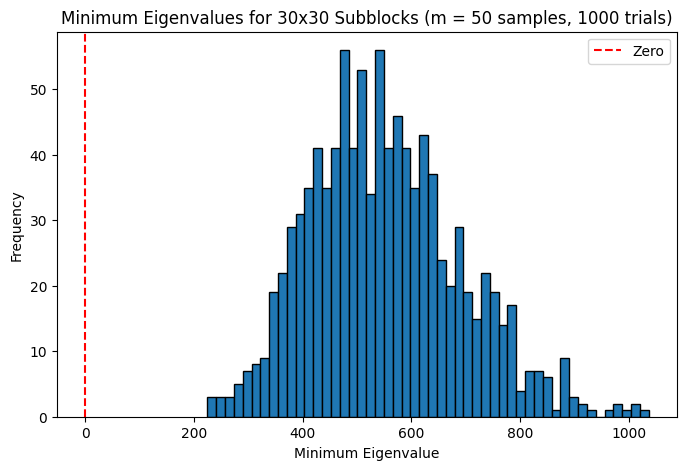

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_full_rank_subblock_sig(n, m, s, iterations=1000, tol=1e-8):
    """
    Simulates the formation of A = L^T Σ L, where:
      - Σ is the covariance matrix computed as Σ = ∑_{i=1}^m x_i x_i^T = X X^T,
        with X an n x m matrix whose columns x_i are independent samples in ℝⁿ.
      - L is an independent n x m matrix with i.i.d. standard Gaussian (sub-Gaussian) entries.

    The matrix A is of size m x m. We then examine a random s x s principal submatrix A_S of A
    (with s <= m) by checking its minimum eigenvalue. If the minimum eigenvalue is positive
    (up to a tolerance), then A_S is considered full rank.

    Parameters:
      n : int
          Ambient dimension, i.e. each sample x_i ∈ ℝⁿ.
      m : int
          Number of samples (and thus the number of columns in X and L). Typically m << n.
      s : int
          Size of the principal subblock (s x s) to be examined; require s ≤ m.
      iterations : int
          Number of simulation runs.
      tol : float
          Tolerance used to determine if an eigenvalue is positive.

    Returns:
      probability : float
          The empirical probability that a random s x s subblock is full rank.
      min_eigenvalues : list of floats
          The minimum eigenvalues of the subblocks over the simulation runs.
    """

    count_full_rank = 0
    min_eigenvalues = []

    for _ in range(iterations):
        # Generate X: n x m matrix; each column is an independent sample in ℝⁿ.
        X = np.random.randn(n, m)
        # Compute the covariance matrix: Σ = sum_{i=1}^m x_i x_i^T = X X^T.
        Sigma = X @ X.T

        # Generate L: an independent n x m matrix with i.i.d. sub-Gaussian (standard Gaussian) entries.
        L = np.random.randn(n, m)

        # Form A = L^T Σ L; A is an m x m matrix.
        A = L.T @ Sigma @ L

        # Randomly choose s indices out of the available m indices for the principal submatrix.
        indices = np.sort(np.random.choice(m, s, replace=False))
        # Extract the s x s principal submatrix A_S corresponding to these indices.
        A_S = A[np.ix_(indices, indices)]

        # Compute the eigenvalues of A_S.
        eigvals = np.linalg.eigvalsh(A_S)
        min_eig = np.min(eigvals)
        min_eigenvalues.append(min_eig)

        # Check for numerical full rank (all eigenvalues greater than tolerance).
        rank = np.sum(eigvals > tol)
        if rank == s:
            count_full_rank += 1

    probability = count_full_rank / iterations
    return probability, min_eigenvalues

if __name__ == "__main__":
    # Parameters: n is the ambient dimension, m is the number of samples,
    # and s (subblock size) must satisfy s <= m.
    n = 200     # Ambient dimension (ℝⁿ)
    m = 50      # Number of samples
    s = 30      # Size of the principal subblock (s x s) to be analyzed
    iterations = 1000   # Number of Monte Carlo simulation trials

    prob, min_eigs = simulate_full_rank_subblock_sig(n=n, m=m, s=s, iterations=iterations)
    print(f"Probability that a random {s}x{s} subblock is full rank: {prob:.3f}")

    # Plot a histogram of the minimum eigenvalues of the s x s subblocks.
    plt.figure(figsize=(8, 5))
    plt.hist(min_eigs, bins=50, edgecolor='black')
    plt.title(f"Minimum Eigenvalues for {s}x{s} Subblocks (m = {m} samples, {iterations} trials)")
    plt.xlabel("Minimum Eigenvalue")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label="Zero")
    plt.legend()
    plt.show()


## Proxy KL Div

In [ ]:
import numpy as np

def newton_column(Y, m, j, n, max_iter=100, tol=1e-8):
    """
    Estimate the j-th column (rows j:n) of the Cholesky factor L via Newton's method.
    Uses np.linalg.lstsq so that it is stable even in the singular (m<n) case.
    """
    d = n - j
    z = np.zeros(d)
    z[0] = 1.0  # initial positive diagonal entry
    for _ in range(max_iter):
        Y_band = Y[:, j:n]  # shape: (m, d)
        r = Y_band.dot(z)
        g = np.zeros(d)
        g[0] = -m / z[0]
        g += Y_band.T.dot(r)
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0]**2)
        delta, _, _, _ = np.linalg.lstsq(H, -g, rcond=None)
        z += delta
        if np.linalg.norm(delta) < tol:
            break
    return z

def estimate_cholesky(Y, m, n):
    """
    Estimate the lower-triangular Cholesky factor L from the data Y.
    In the full–rank case (m>n), all n columns are nonzero.
    In the singular case (m<n), only the first r_eff = min(m, n) columns are active.
    """
    L = np.zeros((n, n))
    r_eff = min(m, n)
    for j in range(r_eff):
        z = newton_column(Y, m, j, n)
        L[j:, j] = z
    return L

def get_effective_dimension(L, tol=1e-10):
    """
    Returns r_eff: the number of diagonal entries of L whose absolute value exceeds tol.
    """
    return np.count_nonzero(np.abs(np.diag(L)) > tol)

def block_lanczos(A, V, num_steps):
    """
    Block Lanczos procedure on matrix A (size N x N) starting with V (N x b)
    for num_steps iterations. Returns the block-tridiagonal matrix T (of size (num_steps*b) x (num_steps*b)).
    """
    N, b = V.shape
    P = [V]
    A_blocks = []
    B_blocks = []
    for i in range(num_steps):
        W = A @ P[i]
        if i > 0:
            W = W - P[i-1] @ B_blocks[i-1].T
        A_i = P[i].T @ W
        A_blocks.append(A_i)
        W = W - P[i] @ A_i
        Q, R = np.linalg.qr(W)
        if np.linalg.norm(R) < 1e-12 or i == num_steps - 1:
            break
        B_blocks.append(R)
        P.append(Q)
    L_actual = len(A_blocks)
    T_dim = L_actual * b
    T = np.zeros((T_dim, T_dim))
    for i in range(L_actual):
        T[i*b:(i+1)*b, i*b:(i+1)*b] = A_blocks[i]
        if i < L_actual - 1:
            T[i*b:(i+1)*b, (i+1)*b:(i+2)*b] = B_blocks[i]
            T[(i+1)*b:(i+2)*b, i*b:(i+1)*b] = B_blocks[i].T
    return T

def unified_kl_divergence_block_slq(Sigma, L, q, t, s, k, eps=1e-12):
    """
    Unified block SLQ estimator for the KL divergence.

    Parameters:
      Sigma : Covariance matrix (n x n)
      L     : Cholesky factor (n x n)
      q     : Number of probes per subblock (for averaging)
      t     : Number of subblocks used to cover the effective space.
            (Theory requires \(t > \frac{r_{\mathrm{eff}}}{s}\ln(\frac{r_{\mathrm{eff}}}{\varepsilon})\).)
      s     : Subblock size (each subblock is s x s)
      k     : Number of Lanczos steps (set k = s for unbiased quadrature)
      eps   : Tolerance for clamping eigenvalues (e.g. 1e-12)

    Returns:
      KL divergence estimate (scalar)

    In the full–rank case (m > n), one should set \(t=1\) and \(s=r_{\mathrm{eff}}=n\), so that the estimator reduces to Algorithm~2.
    """
    # Compute effective dimension: r_eff = number of diagonal entries of L with |L_ii| > eps.
    r_eff = get_effective_dimension(L, tol=eps)

    # In full–rank case, one sets t=1 and s = r_eff.
    indices_pool = np.arange(r_eff)

    # The function f:
    def f(x):
        x_clamped = np.maximum(x, eps)
        return x_clamped - np.log(x_clamped) - 1.0

    subblock_estimates = []
    for i in range(t):
        # Sample a subblock S_i (without replacement) from {0,...,r_eff-1}
        S = np.sort(np.random.choice(indices_pool, size=s, replace=False))
        # Extract principal submatrices:
        L_S = L[np.ix_(S, S)]
        Sigma_S = Sigma[np.ix_(S, S)]
        A_S = L_S.T @ (Sigma_S @ L_S)

        probe_estimates = []
        for j in range(q):
            # Generate a random s x s Rademacher matrix and orthonormalize to get V.
            Z = np.random.choice([-1, 1], size=(s, s)).astype(np.float64)
            V, _ = np.linalg.qr(Z)
            # Run block Lanczos on A_S starting from V with k steps.
            T = block_lanczos(A_S, V, num_steps=k)
            eigvals, U = np.linalg.eigh(T)
            # Compute quadrature weights: for each eigenvalue, sum the squares of the entries in the first s rows.
            weights = np.sum(U[0:s, :]**2, axis=0)
            eta = np.sum(weights * f(eigvals))
            probe_estimates.append(eta)
        subblock_estimates.append(np.mean(probe_estimates))

    # Combine subblock estimates:
    trace_est = (r_eff / (t * s)) * np.sum(subblock_estimates)
    return 0.5 * trace_est

# =============================================================================
# Example Usage:
# =============================================================================

if __name__ == "__main__":
    np.random.seed(42)
    n = 200
    mean = np.zeros(n)

    # Full-Rank Case (m > n): set m_samples = 10000, and choose t = 1, s = n, k = n.
    m_samples_full = 10000
    Sigma_full = generate_kernel_matrix(n, sigma=2.0)
    Y_full = np.random.multivariate_normal(mean, Sigma_full, size=m_samples_full)
    L_full = estimate_cholesky(Y_full, m_samples_full, n)
    r_eff_full = get_effective_dimension(L_full)
    print("Full-Rank Case:")
    print("Effective dimension (should be n):", r_eff_full)

    # Direct KL divergence computation (for reference)
    def kl_direct(Sigma, L):
        n = Sigma.shape[0]
        M = L @ L.T @ Sigma
        sign, logdet = np.linalg.slogdet(M)
        return 0.5 * (np.trace(M) - logdet - n)
    kl_direct_val = kl_direct(Sigma_full, L_full)
    print("KL divergence (direct):", kl_direct_val)

    # Unified block SLQ: in full-rank set t = 1 and s = r_eff = n
    kl_est_full = unified_kl_divergence_block_slq(Sigma_full, L_full, q=20, t=1, s=r_eff_full, k=r_eff_full, eps=1e-12)
    print("KL divergence (unified block SLQ, full-rank):", kl_est_full)

    # Singular Case (m < n): set m_samples < n; here m_samples_singular = 50.
    m_samples_singular = 50
    Sigma_singular = generate_kernel_matrix(n, sigma=2.0)
    Y_singular = np.random.multivariate_normal(mean, Sigma_singular, size=m_samples_singular)
    L_singular = estimate_cholesky(Y_singular, m_samples_singular, n)
    r_eff_singular = get_effective_dimension(L_singular)
    print("\nSingular Case:")
    print("Effective dimension (should be m):", r_eff_singular)

    # In the singular case, choose e.g. s=10 subblock size and t such that t > (r_eff/s)*log(r_eff/eps)
    kl_est_singular = unified_kl_divergence_block_slq(Sigma_singular, L_singular, q=20, t=10, s=10, k=10, eps=1e-12)
    print("KL divergence (unified block SLQ, singular):", kl_est_singular)


Full-Rank Case:
Effective dimension (should be n): 200
KL divergence (direct): 1.0449837860731321
KL divergence (unified block SLQ, full-rank): 1.0449837860731344

Singular Case:
Effective dimension (should be m): 50
KL divergence (unified block SLQ, singular): 107966363146446.27


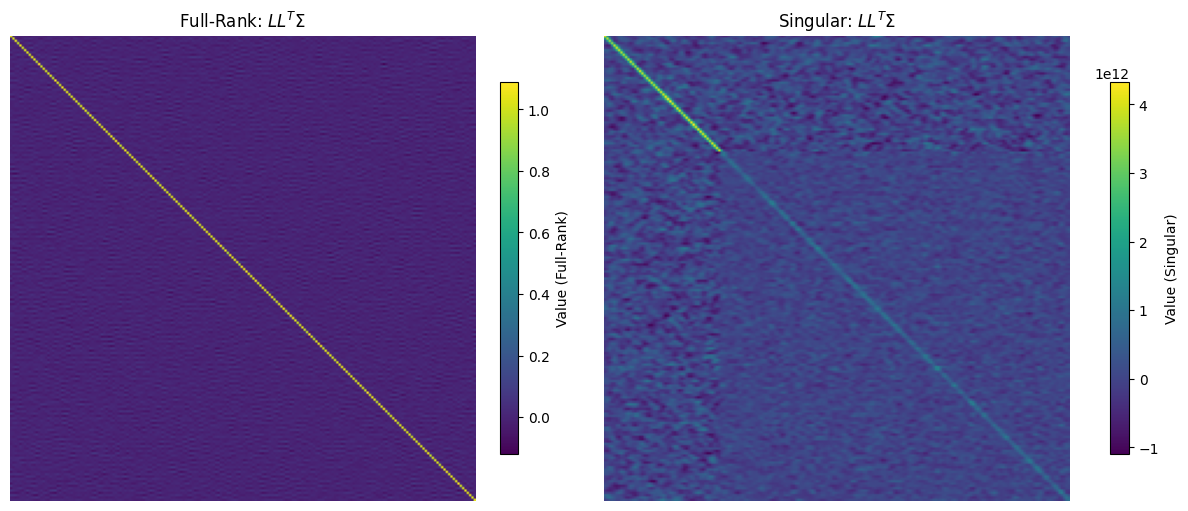

In [ ]:
import matplotlib.pyplot as plt

# Compute the matrix products
M_full = L_full @ L_full.T @ Sigma_full
M_singular = L_singular @ L_singular.T @ Sigma_singular

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot full-rank matrix
im0 = axes[0].imshow(M_full, cmap='viridis')
axes[0].set_title("Full-Rank: $LL^T \Sigma$")
axes[0].axis('off')
cbar0 = fig.colorbar(im0, ax=axes[0], shrink=0.8, orientation='vertical')
cbar0.set_label("Value (Full-Rank)")

# Plot singular matrix
im1 = axes[1].imshow(M_singular, cmap='viridis')
axes[1].set_title("Singular: $LL^T \Sigma$")
axes[1].axis('off')
cbar1 = fig.colorbar(im1, ax=axes[1], shrink=0.8, orientation='vertical')
cbar1.set_label("Value (Singular)")

# Save and show the figure
# plt.savefig("KL_matrix_comparison_dual_colorbar.png", dpi=300)
plt.show()


s = 40, full-rank prob ≈ 1.000
s = 41, full-rank prob ≈ 1.000
s = 42, full-rank prob ≈ 1.000
s = 43, full-rank prob ≈ 1.000
s = 44, full-rank prob ≈ 1.000
s = 45, full-rank prob ≈ 1.000
s = 46, full-rank prob ≈ 1.000
s = 47, full-rank prob ≈ 1.000
s = 48, full-rank prob ≈ 1.000
s = 49, full-rank prob ≈ 1.000
s = 50, full-rank prob ≈ 1.000
s = 51, full-rank prob ≈ 0.000
s = 52, full-rank prob ≈ 0.000
s = 53, full-rank prob ≈ 0.000
s = 54, full-rank prob ≈ 0.000
s = 55, full-rank prob ≈ 0.000
s = 56, full-rank prob ≈ 0.000
s = 57, full-rank prob ≈ 0.000
s = 58, full-rank prob ≈ 0.000
s = 59, full-rank prob ≈ 0.000
s = 60, full-rank prob ≈ 0.000


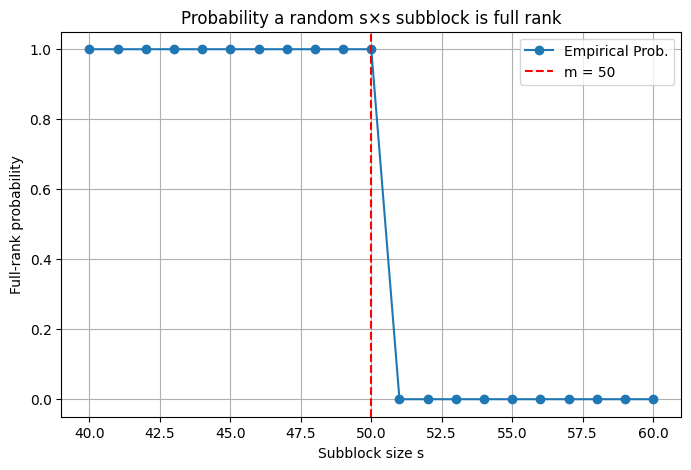

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_full_rank_subblock(n, Sigma, m, s, iterations=500, tol=1e-8):
    """
    Simulates the sample covariance matrix Sigma_hat = sum_{i=1}^m u_i u_i^T
    with u_i ~ N(0, Sigma), and checks full-rank of random s x s subblocks.

    Parameters:
      n : int
          Dimension of the covariance matrix Sigma (n x n).
      Sigma : (n,n) ndarray
          True covariance matrix (must be positive definite).
      m : int
          Number of Gaussian samples (u_i), effective rank <= m.
      s : int
          Subblock size (s x s) to test.
      iterations : int
          Number of simulation runs.
      tol : float
          Tolerance for minimum eigenvalue to declare full rank.

    Returns:
      float : Empirical probability that a random s x s subblock is full rank.
    """
    count_full_rank = 0
    for _ in range(iterations):
        # Generate m samples u_i ~ N(0, Sigma)
        U = np.random.multivariate_normal(mean=np.zeros(n), cov=Sigma, size=m)
        # Form empirical covariance (unnormalized)
        Sigma_hat = U.T @ U
        # Randomly choose s indices for the subblock
        idx = np.random.choice(n, s, replace=False)
        subblock = Sigma_hat[np.ix_(idx, idx)]
        # Check full rank via eigenvalues
        eigs = np.linalg.eigvalsh(subblock)
        if np.min(eigs) > tol:
            count_full_rank += 1
    return count_full_rank / iterations

# Parameters
n = 200
# Construct a full-rank Sigma: diagonal entries ~ Uniform[1,2]
diag_vals = np.random.uniform(1.0, 2.0, size=n)
Sigma = np.diag(diag_vals)

m = 50      # number of samples
s_values = np.arange(40, 61)  # subblock sizes around m
probabilities = []

for s in s_values:
    prob = simulate_full_rank_subblock(n, Sigma, m, s, iterations=200)
    probabilities.append(prob)
    print(f"s = {s:2d}, full-rank prob ≈ {prob:.3f}")

# Plotting
plt.figure(figsize=(8,5))
plt.plot(s_values, probabilities, 'o-', label='Empirical Prob.')
plt.axvline(m, color='red', linestyle='--', label=f'm = {m}')
plt.title("Probability a random s×s subblock is full rank")
plt.xlabel("Subblock size s")
plt.ylabel("Full-rank probability")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
# plt.savefig('prob_fullrank.png', dpi=300)
plt.show()


In [ ]:
import numpy as np

# Setup
np.random.seed(1)
m = 10
n = 20

# Build a rank-m 'covariance'
U = np.random.randn(m, n)
Sigma = U.T @ U

# 1) Good pattern of size m
s_good = 8
C_good = np.sort(np.random.choice(n, s_good, replace=False))
A_good = Sigma[np.ix_(C_good, C_good)]
cond_good = np.linalg.cond(A_good)
rank_good = np.linalg.matrix_rank(A_good)
print(f"Good pattern size {m}: cond={cond_good:.3e}, rank={rank_good}")

# 2) Bad pattern of size m+1
s = m + 1
C_bad = np.sort(np.random.choice(n, s, replace=False))
A_bad = Sigma[np.ix_(C_bad, C_bad)]
cond_bad = np.linalg.cond(A_bad)
rank_bad = np.linalg.matrix_rank(A_bad)
print(f"Bad pattern size {s}: cond={cond_bad:.3e}, rank={rank_bad}")


Good pattern size 10: cond=1.628e+02, rank=8
Bad pattern size 11: cond=4.556e+16, rank=10


Estimating L: 100%|██████████| 180/180 [00:00<00:00, 641.28it/s]



Singular Sparse: r_eff = 180 with k = 30
KL direct: 375.23566607266855
KL SLQ: 82.9819548261873


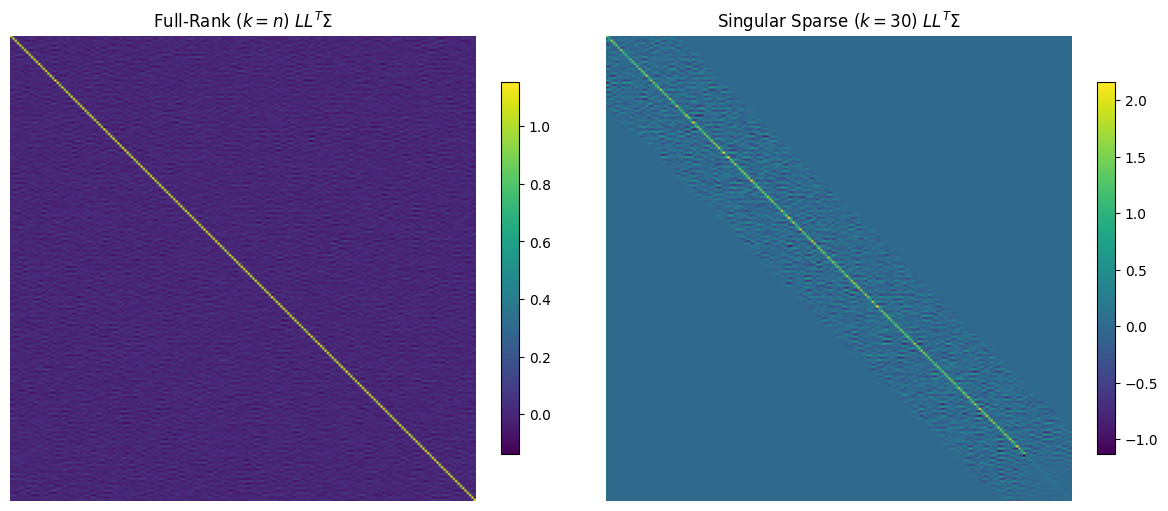

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def generate_kernel_matrix(n, sigma=2.0):
    """
    Generate a positive-definite n x n kernel matrix using a Gaussian kernel.
    """
    x = np.arange(n)
    A = np.exp(-((x[:, None] - x[None, :]) ** 2) / sigma)
    # Ensure positive definiteness
    min_eig = np.min(np.linalg.eigvalsh(A))
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return A

def newton_column_sparse(Y, m, j, n, k, max_iter=100, tol=1e-8):
    """
    Estimate the j-th column of the Cholesky factor L via Newton's method,
    enforcing at most k nonzeros in that column.
    """
    d = min(k, n - j)                    # number of free entries for column j
    z = np.zeros(d)
    z[0] = 1.0                           # initialize diagonal entry

    for _ in range(max_iter):
        Y_band = Y[:, j:j+d]            # shape: (m, d)
        r = Y_band.dot(z)
        g = Y_band.T.dot(r)
        g[0] += -m / z[0]
        H = Y_band.T.dot(Y_band)
        H[0, 0] += m / (z[0]**2)
        # delta, *_ = np.linalg.lstsq(H, -g, rcond=None)
        delta = np.linalg.solve(H, -g)
        z += delta
        if np.linalg.norm(delta) < tol:
            break

    return z

def estimate_cholesky(Y, m, n, k):
    """
    Estimate the lower-triangular Cholesky factor L from data Y,
    enforcing at most k nonzeros per column.
    """
    L = np.zeros((n, n))
    r_eff = min(m, n)
    for j in trange(r_eff, desc="Estimating L"):
        z = newton_column_sparse(Y, m, j, n, k)
        L[j:j+len(z), j] = z
    return L

def get_effective_dimension(L, tol=1e-10):
    """
    Returns r_eff: the number of diagonal entries of L whose absolute value exceeds tol.
    """
    return np.count_nonzero(np.abs(np.diag(L)) > tol)

def block_lanczos(A, V, num_steps):
    """
    Block Lanczos procedure on matrix A starting with V for `num_steps` iterations.
    Returns the block-tridiagonal matrix T.
    """
    N, b = V.shape
    P = [V]
    A_blocks, B_blocks = [], []
    for i in range(num_steps):
        W = A @ P[i]
        if i > 0:
            W -= P[i-1] @ B_blocks[-1].T
        A_i = P[i].T @ W
        A_blocks.append(A_i)
        W -= P[i] @ A_i
        Q, R = np.linalg.qr(W)
        if np.linalg.norm(R) < 1e-12:
            break
        B_blocks.append(R)
        P.append(Q)
    # Assemble T
    L_act = len(A_blocks)
    T = np.zeros((L_act*b, L_act*b))
    for i in range(L_act):
        T[i*b:(i+1)*b, i*b:(i+1)*b] = A_blocks[i]
        if i < L_act-1:
            T[i*b:(i+1)*b, (i+1)*b:(i+2)*b] = B_blocks[i]
            T[(i+1)*b:(i+2)*b, i*b:(i+1)*b] = B_blocks[i].T
    return T

def unified_kl_divergence_block_slq(Sigma, L, q, t, s, k, eps=1e-12):
    """
    Unified block SLQ estimator for the KL divergence.
    """
    r_eff = get_effective_dimension(L, tol=eps)
    indices_pool = np.arange(r_eff)

    def f(x):
        x_clamped = np.maximum(x, eps)
        return x_clamped - np.log(x_clamped) - 1.0

    subblock_est = []
    for _ in range(t):
        S = np.sort(np.random.choice(indices_pool, size=s, replace=False))
        L_S = L[np.ix_(S, S)]
        Sigma_S = Sigma[np.ix_(S, S)]
        A_S = L_S.T @ (Sigma_S @ L_S)

        probes = []
        for _ in range(q):
            Z = np.random.choice([-1,1], size=(s, s)).astype(float)
            V, _ = np.linalg.qr(Z)
            T = block_lanczos(A_S, V, num_steps=k)
            eigvals, U = np.linalg.eigh(T)
            weights = np.sum(U[:s, :]**2, axis=0)
            probes.append(np.sum(weights * f(eigvals)))
        subblock_est.append(np.mean(probes))

    trace_est = (r_eff / (t*s)) * np.sum(subblock_est)
    return 0.5 * trace_est

def kl_direct(Sigma, L):
    """
    Direct KL divergence: D = 0.5 * [tr(M) - log det(M) - n] with M = L L^T Sigma.
    """
    n = Sigma.shape[0]
    M = L @ L.T @ Sigma
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * (np.trace(M) - logdet - n)

# =============================================================================
# Main experiment
# =============================================================================
if __name__ == "__main__":
    np.random.seed(42)
    n = 200
    mean = np.zeros(n)

    # # Full-Rank Case: no sparsity constraint (k = n)
    # m_full = 5000
    # Sigma_full = generate_kernel_matrix(n, sigma=2.0)
    # Y_full = np.random.multivariate_normal(mean, Sigma_full, size=m_full)
    # L_full = estimate_cholesky(Y_full, m_full, n, k=n)
    # r_full = get_effective_dimension(L_full)
    # print("Full-Rank: r_eff =", r_full)
    # print("KL direct:", kl_direct(Sigma_full, L_full))
    # kl_full = unified_kl_divergence_block_slq(Sigma_full, L_full, q=20, t=1, s=r_full, k=r_full)
    # print("KL SLQ:", kl_full)

    # Singular Case:
    m_sing = 180
    percentage = 0.6  #percentage of sparisity relative to number of samples
    # k_sing = int(m_sing*percentage)
    k_sing = 30
    Sigma_sing = generate_kernel_matrix(n, sigma=2.0)
    Y_sing = np.random.multivariate_normal(mean, Sigma_sing, size=m_sing)
    L_sing = estimate_cholesky(Y_sing, m_sing, n, k=k_sing)
    r_sing = get_effective_dimension(L_sing)
    print("\nSingular Sparse: r_eff =", r_sing, "with k =", k_sing)
    print("KL direct:", kl_direct(Sigma_sing, L_sing))
    kl_sing = unified_kl_divergence_block_slq(Sigma_sing, L_sing, q=20, t=10, s=k_sing, k=k_sing)
    print("KL SLQ:", kl_sing)

    # Plotting the two matrices M = L L^T Sigma
    M_full = L_full @ L_full.T @ Sigma_full
    M_sing = L_sing @ L_sing.T @ Sigma_sing

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    im0 = axes[0].imshow(M_full, cmap='viridis')
    axes[0].set_title("Full-Rank ($k=n$) $LL^T \Sigma$")
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], shrink=0.8)

    im1 = axes[1].imshow(M_sing, cmap='viridis')
    axes[1].set_title(f"Singular Sparse ($k={k_sing}$) $LL^T \Sigma$")
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], shrink=0.8)
    # plt.savefig("KL_matrix_comparison_dual_sprase.png", dpi=300)

    plt.show()


Benchmarking:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-3-ce6ea1615bfe>:20: RuntimeWarning: invalid value encountered in log
  def f(x): return x - np.log(x) - 1.0
Benchmarking: 100%|██████████| 10/10 [06:21<00:00, 38.14s/it]


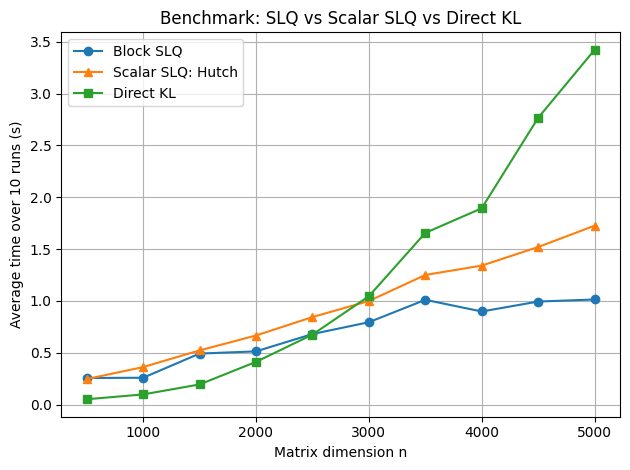

In [ ]:
import time
import numpy as np
import scipy.sparse as sp
from numpy.linalg import cholesky, slogdet
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Helper functions ---

def generate_kernel_matrix_sparse(n, sigma=2.0):
    idx = np.arange(n)
    D2 = (idx[:, None] - idx[None, :]) ** 2
    A = np.exp(-D2 / sigma)
    min_eig = np.linalg.eigvalsh(A).min()
    if min_eig < 1e-8:
        A += (1e-8 - min_eig) * np.eye(n)
    return sp.csr_matrix(A)

def randomized_kl_divergence_block_vectorized(num_probes, block_size, lanczos_steps, L_sp, Sigma_sp):
    def f(x): return x - np.log(x) - 1.0
    SL_sp = Sigma_sp.dot(L_sp)
    full_batches = num_probes // block_size
    rem = num_probes % block_size
    batch_sizes = [block_size] * full_batches + ([rem] if rem else [])
    estimates = []
    for p in batch_sizes:
        Z = np.random.choice([-1, 1], size=(L_sp.shape[0], p)).astype(float)
        Q, _ = np.linalg.qr(Z)
        P_blocks, A_blocks, B_blocks = [Q], [], []
        for _ in range(lanczos_steps):
            W = L_sp.T @ (SL_sp @ P_blocks[-1])
            i = len(A_blocks)
            if i > 0:
                W -= P_blocks[i-1] @ B_blocks[i-1].T
            A_i = P_blocks[i].T @ W
            W -= P_blocks[i] @ A_i
            Qn, Rn = np.linalg.qr(W)
            if np.linalg.norm(Rn) < 1e-12:
                break
            A_blocks.append(A_i)
            B_blocks.append(Rn)
            P_blocks.append(Qn)
        m_act = len(A_blocks)
        T = np.zeros((m_act*p, m_act*p))
        for i in range(m_act):
            i0, i1 = i*p, (i+1)*p
            T[i0:i1, i0:i1] = A_blocks[i]
            if i < m_act-1:
                j0, j1 = (i+1)*p, (i+2)*p
                T[i0:i1, j0:j1] = B_blocks[i]
                T[j0:j1, i0:i1] = B_blocks[i].T
        eigvals, Q_T = np.linalg.eigh(T)
        weights = np.sum(Q_T[:p, :]**2, axis=0)
        trace_est = (L_sp.shape[0]/p) * np.sum(weights * f(eigvals))
        estimates.append(0.5 * trace_est)
    return np.mean(estimates)

def kl_divergence_direct(Sigma_sp, L_sp):
    M = (L_sp @ L_sp.T).dot(Sigma_sp).toarray()
    tr = np.trace(M)
    sign, logdet = slogdet(M)
    return 0.5 * (tr - logdet - M.shape[0])

def randomized_kl_divergence_scalar(num_probes, lanczos_steps, L_sp, Sigma_sp):
    def f(x): return x - np.log(x) - 1.0
    n = L_sp.shape[0]
    estimates = []
    for _ in range(num_probes):
        # Rademacher vector
        z = np.random.choice([-1,1], size=n).astype(float)
        q = z/np.linalg.norm(z)
        q_prev = np.zeros(n)
        alpha = np.zeros(lanczos_steps)
        beta  = np.zeros(lanczos_steps+1)
        k_actual = lanczos_steps
        for j in range(lanczos_steps):
            # sparse mat-vec
            w = L_sp.T @ (Sigma_sp.dot(L_sp.dot(q)))
            if j > 0:
                w -= beta[j] * q_prev
            alpha[j] = q.dot(w)
            w -= alpha[j] * q
            beta[j+1] = np.linalg.norm(w)
            if beta[j+1] < 1e-12:
                k_actual = j+1
                break
            q_prev = q
            q = w / beta[j+1]
        alpha = alpha[:k_actual]
        beta  = beta[:k_actual+1]
        # build tridiagonal T
        T = np.diag(alpha)
        for i in range(k_actual-1):
            T[i,i+1] = beta[i+1]
            T[i+1,i] = beta[i+1]
        eigvals, U = np.linalg.eigh(T)
        estimates.append(n * np.sum((U[0,:]**2) * f(eigvals)))
    return 0.5 * np.mean(estimates)

# --- Benchmarking ---

sigma = 2.0
num_probes = 20
lanczos_steps = 30
block_size = 5
n_list = list(range(500, 5001, 500))
trials = 10

times_vect  = {n: [] for n in n_list}
times_direct= {n: [] for n in n_list}
times_scalar= {n: [] for n in n_list}

for n in tqdm(n_list, desc="Benchmarking"):
    Sigma_sp = generate_kernel_matrix_sparse(n, sigma)
    Sigma_dn = Sigma_sp.toarray()
    L = cholesky(Sigma_dn + 1e-8*np.eye(n))
    L_sp = sp.csr_matrix(L)
    for _ in range(trials):
        t0 = time.perf_counter()
        _ = randomized_kl_divergence_block_vectorized(num_probes, block_size, lanczos_steps, L_sp, Sigma_sp)
        times_vect[n].append(time.perf_counter() - t0)
        t1 = time.perf_counter()
        _ = kl_divergence_direct(Sigma_sp, L_sp)
        times_direct[n].append(time.perf_counter() - t1)
        t2 = time.perf_counter()
        _ = randomized_kl_divergence_scalar(num_probes, lanczos_steps, L_sp, Sigma_sp)
        times_scalar[n].append(time.perf_counter() - t2)

# Compute averages
avg_vect   = [np.mean(times_vect[n])   for n in n_list]
avg_direct = [np.mean(times_direct[n]) for n in n_list]
avg_scalar = [np.mean(times_scalar[n]) for n in n_list]

# Plot
plt.figure()
plt.plot(n_list, avg_vect,   marker='o', label='Block SLQ')
plt.plot(n_list, avg_scalar, marker='^', label='Scalar SLQ: Hutch')
plt.plot(n_list, avg_direct, marker='s', label='Direct KL')
plt.xlabel('Matrix dimension n')
plt.ylabel(f'Average time over {trials} runs (s)')
plt.title('Benchmark: SLQ vs Scalar SLQ vs Direct KL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("timing_comparison.png", dpi=300)


Budgets: 100%|██████████| 7/7 [01:37<00:00, 13.91s/it]


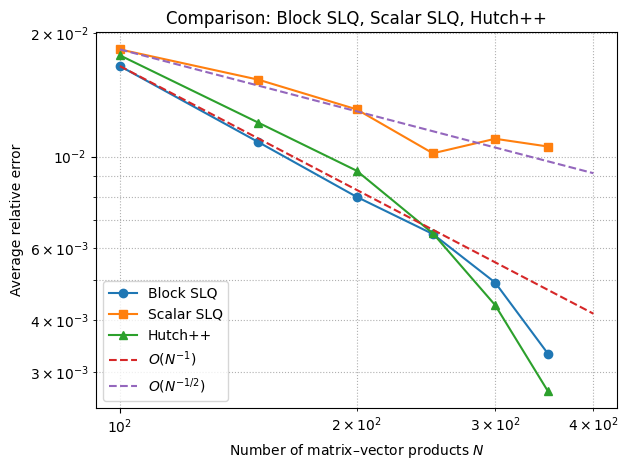

In [ ]:
# f(A) = A^2 as function here
# with Cholesky estimate L^Tf(A)L
# this is for KL divergence estimation

import numpy as np
import scipy.sparse as sp
from numpy.linalg import cholesky
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Helper functions ---

def generate_kernel_matrix_sparse(n, sigma=2.0):
    idx = np.arange(n)
    D2 = (idx[:, None] - idx[None, :])**2
    A = np.exp(-D2/sigma)
    min_eig = np.linalg.eigvalsh(A).min()
    if min_eig < 1e-8:
        A += (1e-8 - min_eig)*np.eye(n)
    return sp.csr_matrix(A)

def apply_A2(X, A_mat):
    """Apply A^2 to X: (A_mat @ (A_mat @ X))."""
    return A_mat.dot(A_mat.dot(X))

def kl_direct(A_mat):
    return np.trace(A_mat.dot(A_mat))

def randomized_block_one_probe(b, L_sp, Sigma_sp):
    n = L_sp.shape[0]
    SL_sp = Sigma_sp.dot(L_sp)
    Z = np.random.choice([-1,1], size=(n, b)).astype(float)
    Q, _ = np.linalg.qr(Z)
    A2Q = L_sp.T.dot(SL_sp.dot(L_sp.T.dot(SL_sp.dot(Q))))
    return (n/b) * np.sum(Q * A2Q)

def randomized_scalar(q, L_sp, Sigma_sp):
    n = L_sp.shape[0]
    SL_sp = Sigma_sp.dot(L_sp)
    Z = np.random.choice([-1,1], size=(n, q)).astype(float)
    Q = Z / np.linalg.norm(Z, axis=0)
    A2Q = L_sp.T.dot(SL_sp.dot(L_sp.T.dot(SL_sp.dot(Q))))
    return (n/q) * np.sum(Q * A2Q)

def randomized_hutchpp(m_budget, A_mat):
    """
    Hutch++ for trace(A^2).
    m_budget = number of A^2 applications we can do (each counts as 2 mat-vecs).
    """
    n = A_mat.shape[0]
    m = m_budget  # number of B= A^2 queries
    sb = m // 3
    sg = m - sb
    # sample S
    S = np.random.choice([-1,1], size=(n, sb)).astype(float)
    # orthonormalize AS: Q = QR(B @ S)
    B_S = apply_A2(S, A_mat)
    Q, _ = np.linalg.qr(B_S)
    # exact term
    B_Q = apply_A2(Q, A_mat)
    term1 = np.trace(Q.T @ B_Q)
    # remainder probes
    G = np.random.choice([-1,1], size=(n, sg)).astype(float)
    G = G / np.linalg.norm(G, axis=0)
    B_G = apply_A2(G, A_mat)
    # project out Q
    R = G - Q @ (Q.T @ G)
    B_R = B_G - Q @ (Q.T @ B_G)
    term2 = (n/sg) * np.sum(R * B_R)
    return term1 + term2

# --- Benchmark parameters ---

n       = 200
sigma   = 2.0
budgets = np.arange(100, 2*n+1, 50)   # up to 400 => B-queries up to 200
trials  = 150

# Prepare matrix and true value
Sigma_sp = generate_kernel_matrix_sparse(n, sigma)
L = cholesky(Sigma_sp.toarray() + 1e-8*np.eye(n))
L_sp = sp.csr_matrix(L)
A_mat = L_sp.T.dot(Sigma_sp.dot(L_sp)).toarray()
true_val = kl_direct(A_mat)

# Storage
errors_block   = np.zeros((len(budgets), trials))
errors_scalar  = np.zeros((len(budgets), trials))
errors_hutchpp = np.zeros((len(budgets), trials))
mv_block_exact = np.zeros(len(budgets), dtype=int)
mv_scalar_exact= np.zeros(len(budgets), dtype=int)
mv_hpp_exact   = np.zeros(len(budgets), dtype=int)

# Run benchmarks
for i, Nmv in enumerate(tqdm(budgets, desc="Budgets")):
    # block: one probe cost = 2*b mat-vecs
    b = min(n, Nmv // 2)
    mv_block_exact[i] = 2 * b
    # scalar: q probes cost = 2*q mat-vecs
    q = max(1, Nmv // 2)
    mv_scalar_exact[i] = 2 * q
    # Hutch++: each B-query = A^2 application = 2 A-vecs, so B_budget = Nmv//2
    B_budget = Nmv // 2
    mv_hpp_exact[i] = Nmv

    for t in range(trials):
        errors_block[i, t]   = abs(randomized_block_one_probe(b, L_sp, Sigma_sp) - true_val) / abs(true_val)
        errors_scalar[i, t]  = abs(randomized_scalar(q, L_sp, Sigma_sp)       - true_val) / abs(true_val)
        errors_hutchpp[i, t] = abs(randomized_hutchpp(B_budget, A_mat)        - true_val) / abs(true_val)

# Averages
avg_block   = errors_block.mean(axis=1)
avg_scalar  = errors_scalar.mean(axis=1)
avg_hutchpp = errors_hutchpp.mean(axis=1)

# --- Plot ---
plt.figure()
plt.loglog(mv_block_exact[:-1],   avg_block[:-1],   'o-', label='Block SLQ')
plt.loglog(mv_scalar_exact[:-1],  avg_scalar[:-1],  's-', label='Scalar SLQ')
plt.loglog(mv_hpp_exact[:-1],      avg_hutchpp[:-1], '^-', label='Hutch++')

# Reference slopes
# Block: -1, Scalar: -1/2
ref_x1 = np.array([mv_block_exact[0], mv_block_exact[-1]])
c1 = avg_block[0] * ref_x1[0]
plt.loglog(ref_x1, c1/ref_x1, '--', label=r'$O(N^{-1})$')

ref_x2 = np.array([mv_scalar_exact[0], mv_scalar_exact[-1]])
c2 = avg_scalar[0] * np.sqrt(ref_x2[0])
plt.loglog(ref_x2, c2/np.sqrt(ref_x2), '--', label=r'$O(N^{-1/2})$')

plt.xlabel('Number of matrix–vector products $N$')
plt.ylabel('Average relative error')
plt.title('Comparison: Block SLQ, Scalar SLQ, Hutch++')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
# plt.savefig('error_vs_matvec_actual_N.png', dpi=300)



Budgets: 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


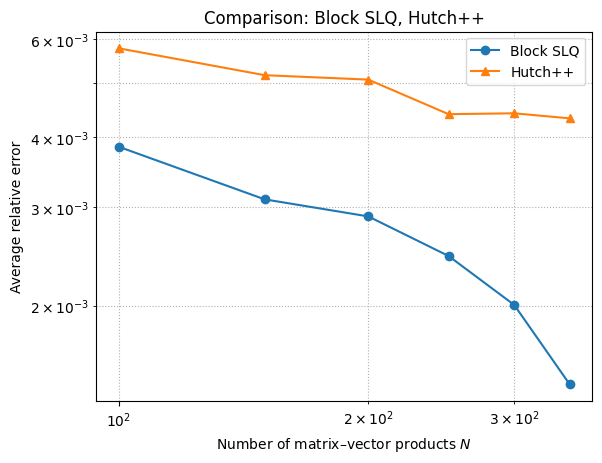

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from tqdm import tqdm

def apply_A2(X, A_mat):
    """Apply A^2 to X: (A_mat @ (A_mat @ X))."""
    return A_mat.dot(A_mat.dot(X))

def kl_direct(A_mat):
    return np.trace(A_mat.dot(A_mat))

def randomized_block_one_probe(b, L_sp, Sigma_sp):
    n = L_sp.shape[0]
    SL_sp = Sigma_sp.dot(L_sp)
    Z = np.random.choice([-1,1], size=(n, b)).astype(float)
    Q, _ = np.linalg.qr(Z)
    A2Q = L_sp.T.dot(SL_sp.dot(L_sp.T.dot(SL_sp.dot(Q))))
    return (n/b) * np.sum(Q * A2Q)


def randomized_hutchpp(m_budget, A_mat):
    """
    Hutch++ for trace(A^2).
    m_budget = number of A^2 applications we can do (each counts as 2 mat-vecs).
    """
    n = A_mat.shape[0]
    sb = m_budget // 3
    sg = m_budget - sb
    # sample S
    S = np.random.choice([-1,1], size=(n, sb)).astype(float)
    # orthonormalize AS: Q = QR(B @ S)
    B_S = apply_A2(S, A_mat)
    Q, _ = np.linalg.qr(B_S)
    # exact term
    B_Q = apply_A2(Q, A_mat)
    term1 = np.trace(Q.T @ B_Q)
    # remainder probes
    G = np.random.choice([-1,1], size=(n, sg)).astype(float)
    G = G / np.linalg.norm(G, axis=0)
    B_G = apply_A2(G, A_mat)
    # project out Q
    R = G - Q @ (Q.T @ G)
    B_R = B_G - Q @ (Q.T @ B_G)
    term2 = (n/sg) * np.sum(R * B_R)
    return term1 + term2

# --- Benchmark parameters ---
n       = 200
budgets = np.arange(100, 2*n+1, 50)   # up to 400 => B-queries up to 200
trials  = 150

# Prepare diagonal Sigma with entries uniform in [1,2]
diag_vals = np.random.uniform(1.0, 2.0, size=n)
Sigma_sp = sp.diags(diag_vals, format='csr')

# Cholesky factor of diagonal Sigma is sqrt of diag entries
L = np.diag(np.sqrt(diag_vals))
L_sp = sp.csr_matrix(L)

# Form A = L^T * Sigma * L = diag(diag_vals^2)
A_mat = L_sp.T.dot(Sigma_sp.dot(L_sp)).toarray()

true_val = kl_direct(A_mat)

# Storage
errors_block   = np.zeros((len(budgets), trials))
errors_hutchpp = np.zeros((len(budgets), trials))
mv_block_exact = np.zeros(len(budgets), dtype=int)
mv_hpp_exact   = np.zeros(len(budgets), dtype=int)

# Run benchmarks
for i, Nmv in enumerate(tqdm(budgets, desc="Budgets")):
    # block: one probe cost = 2*b mat-vecs
    b = min(n, Nmv // 2)
    mv_block_exact[i] = 2 * b
    # Hutch++: each B-query = A^2 application = 2 A-vecs, so B_budget = Nmv//2
    B_budget = Nmv // 2
    mv_hpp_exact[i] = Nmv

    for t in range(trials):
        errors_block[i, t]   = abs(randomized_block_one_probe(b, L_sp, Sigma_sp) - true_val) / abs(true_val)
        errors_hutchpp[i, t] = abs(randomized_hutchpp(B_budget, A_mat)        - true_val) / abs(true_val)

# Averages
avg_block   = errors_block.mean(axis=1)
avg_hutchpp = errors_hutchpp.mean(axis=1)

# --- Plot ---
plt.figure()
plt.loglog(mv_block_exact[:-1],   avg_block[:-1],   'o-', label='Block SLQ')
plt.loglog(mv_hpp_exact[:-1],      avg_hutchpp[:-1], '^-', label='Hutch++')

plt.xlabel('Number of matrix–vector products $N$')
plt.ylabel('Average relative error')
plt.title('Comparison: Block SLQ, Hutch++')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
# plt.savefig('hutchppfail.png', dpi=300)



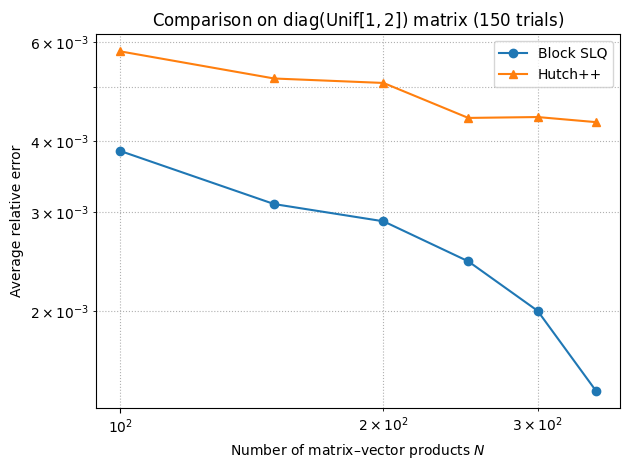

In [ ]:
plt.figure()
plt.loglog(mv_block_exact[:-1],   avg_block[:-1],   'o-', label='Block SLQ')
plt.loglog(mv_hpp_exact[:-1],     avg_hutchpp[:-1], '^-', label='Hutch++')

plt.xlabel('Number of matrix–vector products $N$')
plt.ylabel('Average relative error')
plt.title(r'Comparison on $\mathrm{diag}(\mathrm{Unif}[1,2])$ matrix (150 trials)')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.savefig('hutchppfail.png', dpi=300)


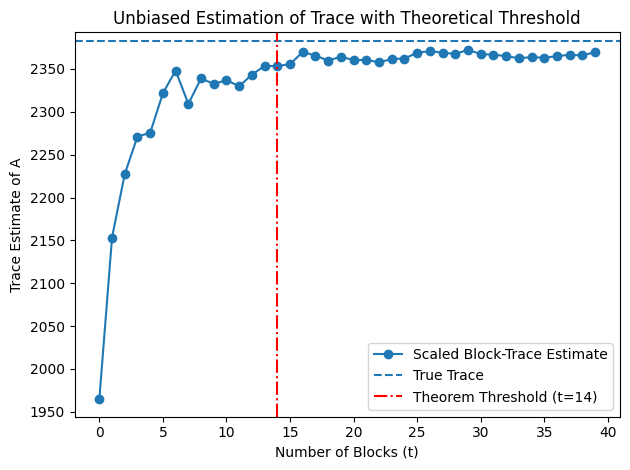

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 50               # Matrix size
s = 10               # Block size
t_max = 40           # Number of blocks to sample
epsilon = 0.1        # Desired failure probability
np.random.seed(0)

# Generate a symmetric positive semidefinite matrix A
B = np.random.randn(n, n)
A = B.T @ B

# True trace of A
true_trace = np.trace(A)

# Sample blocks and record their traces
block_traces = []
for _ in range(t_max):
    S = np.random.choice(n, s, replace=False)
    block_trace = np.trace(A[np.ix_(S, S)])
    block_traces.append(block_trace)

# Compute unbiased estimates: (n/s) * average block trace
estimates = [(n / s) * np.mean(block_traces[:i+1]) for i in range(t_max)]

# Compute theoretical threshold t based on Full Coverage theorem
t_threshold = int(np.ceil((n / s) * np.log10(n / epsilon)))

# Plot convergence of the estimator with threshold line
plt.figure()
plt.plot(estimates, marker='o', label='Scaled Block-Trace Estimate')
plt.axhline(true_trace, linestyle='--', label='True Trace')
plt.axvline(t_threshold, color='red', linestyle='-.', label=f'Theorem Threshold (t={t_threshold})')
plt.xlabel('Number of Blocks (t)')
plt.ylabel('Trace Estimate of A')
plt.title('Unbiased Estimation of Trace with Theoretical Threshold')
plt.legend()
plt.tight_layout()
# plt.savefig('exact_trace_recovery.png', dpi=300)


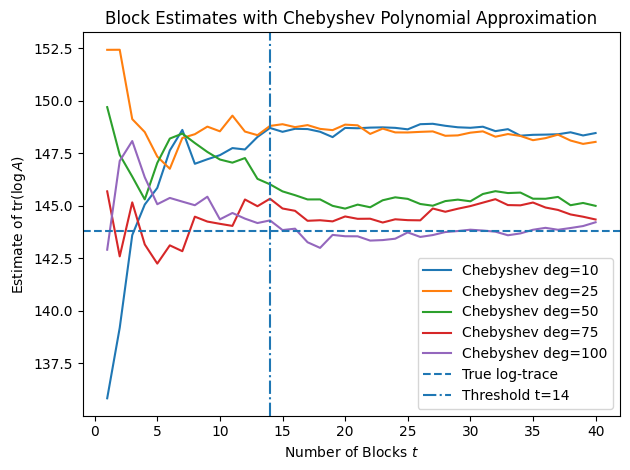

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from numpy.polynomial.chebyshev import chebfit

def extend_indices(A, S, r):
    """Find indices within graph-distance ≤ r of S in the sparsity pattern of A."""
    if sp.issparse(A):
        A_bin = (A != 0).astype(int).tocsr()
    else:
        rows, cols = np.where(A != 0)
        data = np.ones(len(rows), dtype=int)
        A_bin = sp.csr_matrix((data, (rows, cols)), shape=A.shape)
    visited = set(S)
    frontier = set(S)
    for _ in range(r):
        new_frontier = set()
        for i in frontier:
            neighbors = A_bin.indices[A_bin.indptr[i]:A_bin.indptr[i+1]]
            new_frontier.update(neighbors.tolist())
        new_frontier -= visited
        if not new_frontier:
            break
        visited |= new_frontier
        frontier = new_frontier
    return sorted(visited)


def chebyshev_log_approx_block(A, S, m, r):
    """
    Approximate log(A)[S,S] using a degree-m Chebyshev polynomial.
    """
    # Extract neighborhood-submatrix
    S_r = extend_indices(A, S, r)
    A_sub = A[S_r, :][:, S_r].toarray() if sp.issparse(A) else A[np.ix_(S_r, S_r)]
    n_sub = A_sub.shape[0]
    # Spectral bounds
    eigs = np.linalg.eigvalsh(A_sub)
    a, b = eigs[0], eigs[-1]
    # Map A_sub to M in [-1,1]
    M = (2*A_sub - (b + a)*np.eye(n_sub)) / (b - a)
    # Chebyshev nodes and fit
    k = np.arange(m+1)
    x_nodes = np.cos((2*k + 1) * np.pi / (2*(m+1)))
    lam_nodes = (b + a)/2 + (b - a)/2 * x_nodes
    y_nodes = np.log(lam_nodes)
    coeffs = chebfit(x_nodes, y_nodes, m)
    # Evaluate Chebyshev expansion via recurrence
    Tkm2 = np.eye(n_sub)
    if m >= 1:
        Tkm1 = M
    P = coeffs[0] * Tkm2
    if m >= 1:
        P += coeffs[1] * Tkm1
    for j in range(2, m+1):
        T_k = 2 * M.dot(Tkm1) - Tkm2
        P += coeffs[j] * T_k
        Tkm2, Tkm1 = Tkm1, T_k
    logA_sub = P
    # Extract requested block
    idx_map = {v: i for i, v in enumerate(S_r)}
    pos = [idx_map[i] for i in S]
    return logA_sub[np.ix_(pos, pos)]

# Simulation parameters
n, s, t_max, epsilon, r = 50, 10, 40, 0.1, 5
np.random.seed(0)
B = np.random.randn(n, n)
A = B.T @ B + 1e-3 * np.eye(n)
# True log-trace
eigs = np.linalg.eigvalsh(A)
true_log_trace = np.sum(np.log(eigs))
t_threshold = int(np.ceil((n/s)*np.log10(n/epsilon)))

# Compare Chebyshev orders
degrees = [10, 25, 50, 75, 100]
est_cheb = {}
for m in degrees:
    traces = []
    for _ in range(t_max):
        S = np.random.choice(n, s, replace=False)
        block = chebyshev_log_approx_block(A, S, m, r)
        traces.append(np.trace(block))
    est_cheb[m] = [(n/s)*np.mean(traces[:i+1]) for i in range(t_max)]

# Plot
plt.figure()
x = np.arange(1, t_max + 1)
for m, est in est_cheb.items():
    plt.plot(x, est, label=f'Chebyshev deg={m}')
plt.axhline(true_log_trace, linestyle='--', label='True log-trace')
plt.axvline(t_threshold, linestyle='-.', label=f'Threshold t={t_threshold}')
plt.xlabel('Number of Blocks $t$')
plt.ylabel('Estimate of $\mathrm{tr}(\log A)$')
plt.title('Block Estimates with Chebyshev Polynomial Approximation')
plt.legend()
plt.tight_layout()
# plt.savefig('chebyshev_block_estimates.png', dpi=300)
plt.show()


# Localization test

In [ ]:
import numpy as np
import scipy.sparse as sp
import pandas as pd

def generate_sparse_symmetric(n, density=0.1, seed=0):
    rng = np.random.default_rng(seed)
    # random sparse mask
    mask = sp.random(n, n, density=density, data_rvs=lambda k: rng.standard_normal(k), format='csr')
    # symmetrize
    A = sp.triu(mask)
    A = A + A.T
    # ensure zero diagonal
    A.setdiag(0)
    A.eliminate_zeros()
    return A

def bfs_neighborhood(adj, S, r):
    visited = set(S)
    frontier = set(S)
    for _ in range(r):
        next_frontier = set()
        for u in frontier:
            neighbors = adj[u].nonzero()[1]
            for v in neighbors:
                if v not in visited:
                    next_frontier.add(v)
                    visited.add(v)
        frontier = next_frontier
        if not frontier:
            break
    return sorted(visited)

def compute_polynomial(A, m):
    # compute sum_{k=0}^m A^k
    n = A.shape[0]
    I = sp.eye(n, format='csr')
    result = I.copy().astype(float)
    power = I.copy().astype(float)
    for k in range(1, m+1):
        power = power.dot(A)
        result = result + power
    return result

# Parameters
n = 50
density = 0.1
seed = 42
S_size = 5

# Generate random sparse symmetric A
A = generate_sparse_symmetric(n, density, seed)

# Choose a random subset S
rng = np.random.default_rng(seed)
S = rng.choice(n, S_size, replace=False).tolist()

# Evaluate localization for m=1..4
rows = []
for m in range(1, 5):
    r = m
    S_r = bfs_neighborhood(A, S, r)

    A_sub = A[S_r, :][:, S_r].tocsc()

    P_full = compute_polynomial(A, m).toarray()
    P_sub = compute_polynomial(A_sub, m).toarray()

    idx_map = [S_r.index(i) for i in S]
    block_full = P_full[np.ix_(S, S)]
    block_sub = P_sub[np.ix_(idx_map, idx_map)]

    max_diff = np.max(np.abs(block_full - block_sub))
    rows.append({'m': m, 'r': r, 'max_block_diff': max_diff})

df = pd.DataFrame(rows)
print(df)


   m  r  max_block_diff
0  1  1             0.0
1  2  2             0.0
2  3  3             0.0
3  4  4             0.0


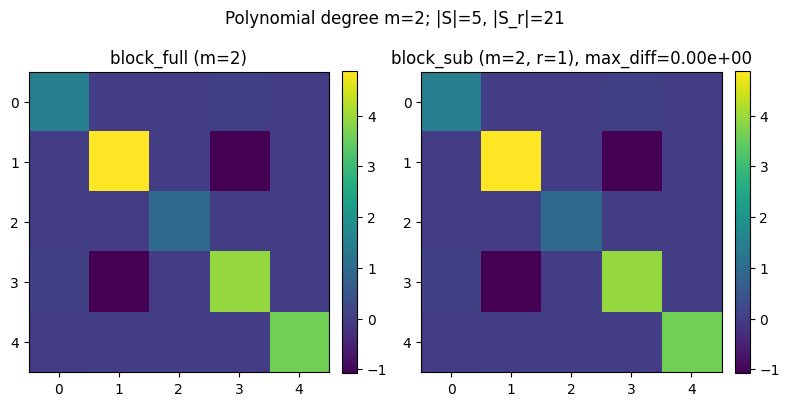

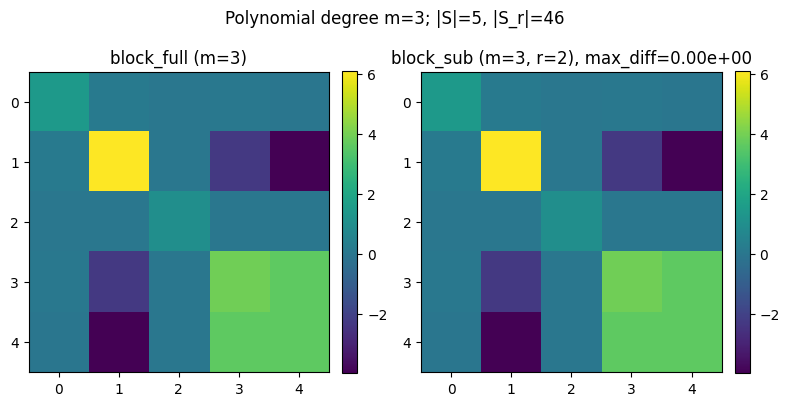

In [ ]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

def generate_sparse_symmetric(n, density=0.1, seed=0):
    rng = np.random.default_rng(seed)
    mask = sp.random(n, n, density=density,
                     data_rvs=lambda k: rng.standard_normal(k),
                     format='csr')
    A = sp.triu(mask, format='csr')
    A = A + A.T
    A.setdiag(0)
    A.eliminate_zeros()
    return A.toarray()

def bfs_neighborhood(adj, S, r):
    visited = set(S)
    frontier = set(S)
    for _ in range(r):
        next_frontier = set()
        for u in frontier:
            neighbors = adj[u].nonzero()[1]
            for v in neighbors:
                if v not in visited:
                    next_frontier.add(v)
                    visited.add(v)
        frontier = next_frontier
        if not frontier:
            break
    return sorted(visited)

def compute_polynomial(A, m):
    """Compute p_m(A) = sum_{k=0}^m A^k"""
    n = A.shape[0]
    I = np.eye(n)
    result = I.copy()
    power = I.copy()
    for k in range(1, m+1):
        power = power.dot(A)
        result += power
    return result

# Parameters
n = 50
density = 0.1
seed = 42
S_size = 5
cases = [2, 3]  # polynomial degrees to test

# Generate A and choose S
np.random.seed(seed)
A = generate_sparse_symmetric(n, density, seed)
rng = np.random.default_rng(seed)
S = rng.choice(n, S_size, replace=False).tolist()

# Test r = m-1 (< m) to see localization break
for m in cases:
    r = m - 1
    S_r = bfs_neighborhood(sp.csr_matrix(A), S, r)

    # Compute full-block
    P_full = compute_polynomial(A, m)
    block_full = P_full[np.ix_(S, S)]

    # Compute sub-block with too-small neighborhood
    A_sub = A[np.ix_(S_r, S_r)]
    P_sub = compute_polynomial(A_sub, m)
    idx_map = [S_r.index(i) for i in S]
    block_sub = P_sub[np.ix_(idx_map, idx_map)]

    max_diff = np.max(np.abs(block_full - block_sub))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(block_full, cmap='viridis', aspect='equal')
    axes[0].set_title(f'block_full (m={m})')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(block_sub, cmap='viridis', aspect='equal')
    axes[1].set_title(f'block_sub (m={m}, r={r}), max_diff={max_diff:.2e}')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.suptitle(f'Polynomial degree m={m}; |S|={len(S)}, |S_r|={len(S_r)}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
